# Ion channel challenge: stratified split, SMOTE, 139 features



In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Input, Conv1D, Dense, LSTM, BatchNormalization, Activation, Dropout, Lambda, 
                                     Multiply, Add, Concatenate, Flatten, MaxPooling1D)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras import backend as K
import tensorflow as tf

from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
#  Inspired by https://www.kaggle.com/siavrez/wavenet-keras?scriptVersionId=31418572
def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):

    def build_residual_block(l_input):
        resid_input = l_input
        for dilation_rate in [2**i for i in range(stacked_layer)]:
            l_sigmoid_conv1d = Conv1D(
              num_filters, kernel_size, dilation_rate=dilation_rate,
              padding='same', activation='sigmoid')(l_input)
            l_tanh_conv1d = Conv1D(
             num_filters, kernel_size, dilation_rate=dilation_rate,
             padding='same', activation='mish')(l_input)
            l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            l_input = Conv1D(num_filters, 1, padding='same')(l_input)
            resid_input = Add()([resid_input ,l_input])
        return resid_input
    return build_residual_block

In [3]:
#  from https://www.kaggle.com/siavrez/wavenet-keras?scriptVersionId=31418572

def mish(x):
    y = x*K.tanh(K.softplus(x))
    return y

get_custom_objects().update({'mish': mish})

In [4]:
def make_array(df):
    df_temp = df.to_numpy()
    df= np.expand_dims(df_temp, axis=0)
    df = df[ ..., np.newaxis]
    return df

In [5]:
def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':

                if (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df

In [6]:
def decay_short(epoch):
    if epoch < 30:    
        return 1e-3
    elif epoch >= 30 and epoch < 60:
        return 5e-4
    elif epoch >= 60 and epoch < 120:
        return 1e-4
    else:
        return 5e-5

def decay_long(epoch):
    if epoch < 100:
        return 1e-3
    elif epoch >= 100 and epoch < 200:
        return 5e-4
    elif epoch >= 200 and epoch < 500:
        return 1e-4
    else:
        return 5e-4

The signal with kalman filter was downloaded from [michaln](https://www.kaggle.com/michaln/data-without-drift-with-kalman-filter).
We added features in three notebooks ([here](https://github.com/berenice-d/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Feature%20Engineering%201.ipynb), [here](https://github.com/berenice-d/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Feature%20engineering%202.ipynb) and [here](https://github.com/berenice-d/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Feature%20engineering%203.ipynb)), and Catboost predictions in [this notebook](https://github.com/berenice-d/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Catboost%20key%20models.ipynb).

## Load and setup data
See [this notebook](https://github.com/berenice-d/Ion-channels/blob/master/notebooks/Ion%20channel%20-%20Catboost%20key%20models.ipynb) and [Deep channel GitHub](https://github.com/RichardBJ/Deep-Channel/blob/master/deepchannel_train.py)

In [7]:
# Load data
train = pd.read_csv('../data/interim/train_2.1.7.1catpred.csv')#.sample(frac=1, random_state=134)
test = pd.read_csv('../data/interim/test_2.1.7.1catpred.csv')

In [8]:
y = train.open_channels
X = train.drop(['open_channels'], axis=1)

In [9]:
# from https://www.kaggle.com/kmat2019/u-net-1d-cnn-with-keras
# I don't use "time" feature
X = X.values.reshape(-1,5000,X.shape[1])#number_of_data:1250 x time_step:4000


X_test = test.values.reshape(-1, 5000,test.shape[1])#

y = to_categorical(y).reshape(-1,5000,11)#classification


In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=134)
print("X_train:{}, X_validation:{}, y_train:{}, y_validation:{}".format(X_train.shape, X_validation.shape, 
                                                                        y_train.shape, y_validation.shape))

X_train:(800, 5000, 6), X_validation:(200, 5000, 6), y_train:(800, 5000, 11), y_validation:(200, 5000, 11)


In [11]:
X_test.shape

(400, 5000, 6)

## Wavenet model 92

This last model was saved as 2.2.6_11. 

LB score:0.94 F1 score:0.95661


In [12]:
tf.keras.backend.clear_session()

In [13]:
num_filters_ = 32 
kernel_size_ = 2
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[2]
stacked_layers_ = [8, 4, 2, 1]
input_shape = (n_timesteps, n_features)
LR = 0.0001

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
lrs = LearningRateScheduler(decay_long)

In [14]:
l_input = Input(shape=(input_shape))
x = Conv1D(num_filters_, 1, padding='same')(l_input)
#, bias_regularizer=l2(0.01), kernel_regularizer=l2(0.01)
x = BatchNormalization()(x)
x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
x = Conv1D(num_filters_*2, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
x = Conv1D(num_filters_*4, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
x = Conv1D(num_filters_*8, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
#x = BatchNormalization()(x)
x = Dense(1500, activation='relu')(x)
l_output = Dense(11, activation='softmax')(x)
model = models.Model(inputs=[l_input], outputs=[l_output])
opt = Adam(lr=LR)
opt = tfa.optimizers.SWA(opt)
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 6)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5000, 32)     224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5000, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5000, 32)     2080        batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, 
          validation_data=(X_validation,y_validation), callbacks=[mc, es, lrs]) # 

Epoch 1/500
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
25/25 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.4677
Epoch 00001: val_loss improved from inf to 6.88316, saving model to best_model.h5
25/25 [==============================] - 9s 350ms/step - loss: 1.4046 - accuracy: 0.4677 - val_loss: 6.8832 - val_accuracy: 0.2823 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.6693
Epoch 00002: val_loss improved from 6.88316 to 3.34750, saving model to best_model.h5
25/25 [==============================] - 8s 314ms/step - loss: 0.8684 - accuracy: 0.6693 - val_loss: 3.3475 - val_accuracy: 0.3204 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.7748
Epoch 00003: val_loss improved from 3.34750 to 2.34155, saving model to best_model.h5
25/25 [==============================] - 8s 314ms/step - loss: 0.6098 - accuracy: 0.7748 - v

Epoch 27/500
25/25 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9507
Epoch 00027: val_loss improved from 0.11025 to 0.10011, saving model to best_model.h5
25/25 [==============================] - 8s 304ms/step - loss: 0.1479 - accuracy: 0.9507 - val_loss: 0.1001 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 28/500
25/25 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9617
Epoch 00028: val_loss did not improve from 0.10011
25/25 [==============================] - 7s 292ms/step - loss: 0.1256 - accuracy: 0.9617 - val_loss: 0.1044 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 29/500
25/25 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9620
Epoch 00029: val_loss did not improve from 0.10011
25/25 [==============================] - 7s 292ms/step - loss: 0.1200 - accuracy: 0.9620 - val_loss: 0.1059 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 30/500
25/25 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9

Epoch 82/500
25/25 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9607
Epoch 00082: val_loss did not improve from 0.07899
25/25 [==============================] - 8s 304ms/step - loss: 0.1263 - accuracy: 0.9607 - val_loss: 0.0957 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 83/500
25/25 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9635
Epoch 00083: val_loss did not improve from 0.07899
25/25 [==============================] - 7s 293ms/step - loss: 0.1166 - accuracy: 0.9635 - val_loss: 0.1578 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 84/500
25/25 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9709
Epoch 00084: val_loss did not improve from 0.07899
25/25 [==============================] - 7s 292ms/step - loss: 0.0981 - accuracy: 0.9709 - val_loss: 0.1243 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 85/500
25/25 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9734
Epoch 00085: val_loss did not i

Epoch 136/500
25/25 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9732
Epoch 00136: val_loss did not improve from 0.07248
25/25 [==============================] - 8s 309ms/step - loss: 0.0870 - accuracy: 0.9732 - val_loss: 0.0814 - val_accuracy: 0.9763 - lr: 5.0000e-04
Epoch 137/500
25/25 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9752
Epoch 00137: val_loss did not improve from 0.07248
25/25 [==============================] - 8s 307ms/step - loss: 0.0836 - accuracy: 0.9752 - val_loss: 0.0746 - val_accuracy: 0.9769 - lr: 5.0000e-04
Epoch 138/500
25/25 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9767
Epoch 00138: val_loss did not improve from 0.07248
25/25 [==============================] - 8s 311ms/step - loss: 0.0760 - accuracy: 0.9767 - val_loss: 0.0729 - val_accuracy: 0.9772 - lr: 5.0000e-04
Epoch 139/500
25/25 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9767
Epoch 00139: va

Epoch 163/500
25/25 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9770
Epoch 00163: val_loss did not improve from 0.07170
25/25 [==============================] - 8s 308ms/step - loss: 0.0735 - accuracy: 0.9770 - val_loss: 0.0721 - val_accuracy: 0.9772 - lr: 5.0000e-04
Epoch 164/500
25/25 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9770
Epoch 00164: val_loss did not improve from 0.07170
25/25 [==============================] - 8s 307ms/step - loss: 0.0738 - accuracy: 0.9770 - val_loss: 0.0727 - val_accuracy: 0.9768 - lr: 5.0000e-04
Epoch 165/500
25/25 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9769
Epoch 00165: val_loss did not improve from 0.07170
25/25 [==============================] - 8s 307ms/step - loss: 0.0739 - accuracy: 0.9769 - val_loss: 0.0719 - val_accuracy: 0.9771 - lr: 5.0000e-04
Epoch 166/500
25/25 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9771
Epoch 00166: va

Epoch 191/500
25/25 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9663
Epoch 00191: val_loss did not improve from 0.07149
25/25 [==============================] - 7s 299ms/step - loss: 0.1182 - accuracy: 0.9663 - val_loss: 0.1533 - val_accuracy: 0.9509 - lr: 5.0000e-04
Epoch 192/500
25/25 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.8210
Epoch 00192: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 306ms/step - loss: 0.6978 - accuracy: 0.8210 - val_loss: 0.7130 - val_accuracy: 0.8453 - lr: 5.0000e-04
Epoch 193/500
25/25 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9330
Epoch 00193: val_loss did not improve from 0.07149
25/25 [==============================] - 7s 297ms/step - loss: 0.2599 - accuracy: 0.9330 - val_loss: 0.1650 - val_accuracy: 0.9473 - lr: 5.0000e-04
Epoch 194/500
25/25 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9661
Epoch 00194: va

Epoch 219/500
25/25 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9758
Epoch 00219: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 300ms/step - loss: 0.0802 - accuracy: 0.9758 - val_loss: 0.0753 - val_accuracy: 0.9769 - lr: 1.0000e-04
Epoch 220/500
25/25 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9757
Epoch 00220: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 302ms/step - loss: 0.0808 - accuracy: 0.9757 - val_loss: 0.0752 - val_accuracy: 0.9770 - lr: 1.0000e-04
Epoch 221/500
25/25 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9759
Epoch 00221: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 303ms/step - loss: 0.0804 - accuracy: 0.9759 - val_loss: 0.0753 - val_accuracy: 0.9769 - lr: 1.0000e-04
Epoch 222/500
25/25 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9760
Epoch 00222: va

Epoch 247/500
25/25 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9767
Epoch 00247: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 303ms/step - loss: 0.0768 - accuracy: 0.9767 - val_loss: 0.0736 - val_accuracy: 0.9772 - lr: 1.0000e-04
Epoch 248/500
25/25 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9761
Epoch 00248: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 302ms/step - loss: 0.0788 - accuracy: 0.9761 - val_loss: 0.0736 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 249/500
25/25 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9761
Epoch 00249: val_loss did not improve from 0.07149
25/25 [==============================] - 8s 303ms/step - loss: 0.0788 - accuracy: 0.9761 - val_loss: 0.0738 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 250/500
25/25 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9765
Epoch 00250: va

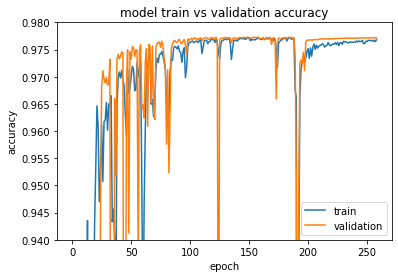

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.94,0.98))
plt.legend(['train', 'validation'])
plt.show()

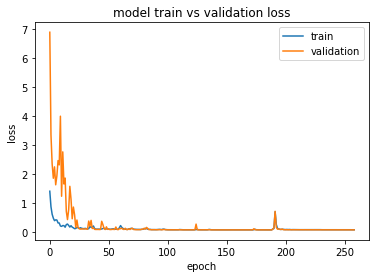

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
# Retrieve the model from saved or use dierectly - uncomment as needed
#saved_model = load_model('best_model.h5')
saved_model = model

# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_validation, y_validation, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.977, Test: 0.977


In [20]:
pred = np.argmax((saved_model.predict(X_validation)+saved_model.predict(X_validation[:,::-1,:])[:,::-1,:])/2, axis=2).reshape(-1)
gt = np.argmax(y_validation, axis=2).reshape(-1)
print("Macro F1 score: ", np.round(f1_score(gt, pred, average="macro"), 5))

Macro F1 score:  0.95693


In [21]:
saved_model.save('../models/model_2.2.6_11.h5')

In [22]:
pred = np.argmax((saved_model.predict(X_test)+saved_model.predict(X_test[:,::-1,:])[:,::-1,:])/2, axis=2).reshape(-1)

In [23]:
test['open_channels']=pred

In [24]:
test[['time','open_channels']].to_csv('../reports/ion_submission_Wavenet9_2.2.6.csv', 
                                                  index=False, float_format='%.4f')

In [25]:
test.head()

,time,signal,cat_pred,exp,power2,sqroot,open_channels
0,500.0001,-2.6504,0,0.0706,7.0312,-1.6279,0
1,500.0002,-2.8457,0,0.0580,8.1016,-1.6875,0
2,500.0003,-2.8535,0,0.0576,8.1406,-1.6895,0
3,500.0004,-2.4434,0,0.0869,5.9727,-1.5635,0
4,500.0005,-2.6133,0,0.0734,6.8242,-1.6162,0


## Model 86
Wavenet 6 features 4 layers 64 filters 3 kernels - normalize after CNN 1 (no dropout) - LR 0.001 120 epochs

LB 0.94 F1 0.95518

In [26]:
l_input = Input(shape=(input_shape))
x = Conv1D(num_filters_, 1, padding='same')(l_input)
x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
x = Conv1D(num_filters_*2, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
x = Conv1D(num_filters_*4, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
# x = Conv1D(num_filters_*8, 1, padding='same')(x)
# x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
x = BatchNormalization()(x)
l_output = Dense(11, activation='softmax')(x)
model = models.Model(inputs=[l_input], outputs=[l_output])
opt = Adam(lr=LR)
opt = tfa.optimizers.SWA(opt)
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

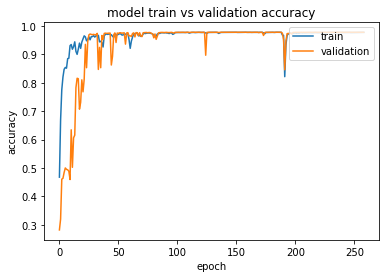

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

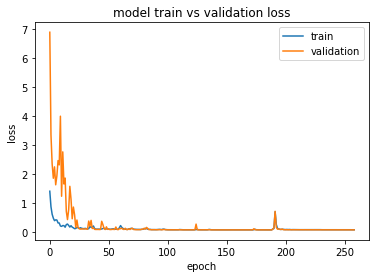

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
saved_model = load_model('best_model.h5')
#saved_model = model
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_validation, y_validation, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.977, Test: 0.977


In [31]:
pred = np.argmax((saved_model.predict(X_validation)+saved_model.predict(X_validation[:,::-1,:])[:,::-1,:])/2, axis=2).reshape(-1)
gt = np.argmax(y_validation, axis=2).reshape(-1)
print("Macro F1 score: ", np.round(f1_score(gt, pred, average="macro"), 5))

Macro F1 score:  0.95703


## With Maxpooling: model 91

In [32]:
num_filters_ = 64 
kernel_size_ = 3
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[2]
stacked_layers_ = [8, 4, 1]
input_shape = (n_timesteps, n_features)
LR = 0.0001

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
lrs = LearningRateScheduler(decay_long)

In [33]:
l_input = Input(shape=(input_shape))
x = Conv1D(num_filters_, 1, padding='same')(l_input)
x = MaxPooling1D(pool_size=2, strides=1, padding="same") (x)
#, bias_regularizer=l2(0.01), kernel_regularizer=l2(0.01)
x = BatchNormalization()(x)
x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
x = Conv1D(num_filters_*2, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
x = Conv1D(num_filters_*4, 1, padding='same')(x)
x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
# x = Conv1D(num_filters_*8, 1, padding='same')(x)
# x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
#x = BatchNormalization()(x)
#x = Dense(2840, activation='relu')(x)
l_output = Dense(11, activation='softmax')(x)
model = models.Model(inputs=[l_input], outputs=[l_output])
opt = Adam(lr=LR)
opt = tfa.optimizers.SWA(opt)
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

In [34]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5000, 6)]    0                                            
__________________________________________________________________________________________________
conv1d_94 (Conv1D)              (None, 5000, 64)     448         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 5000, 64)     0           conv1d_94[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 5000, 64)     256         max_pooling1d[0][0]              
____________________________________________________________________________________________

In [35]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, 
          validation_data=(X_validation,y_validation), callbacks=[mc, es, lrs]) # 

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 1.5044 - accuracy: 0.4442
Epoch 00001: val_loss improved from inf to 7.49040, saving model to best_model.h5
25/25 [==============================] - 9s 347ms/step - loss: 1.5044 - accuracy: 0.4442 - val_loss: 7.4904 - val_accuracy: 0.0665 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 1.0039 - accuracy: 0.6167
Epoch 00002: val_loss improved from 7.49040 to 4.18137, saving model to best_model.h5
25/25 [==============================] - 8s 319ms/step - loss: 1.0039 - accuracy: 0.6167 - val_loss: 4.1814 - val_accuracy: 0.3144 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.6922
Epoch 00003: val_loss improved from 4.18137 to 1.72842, saving model to best_model.h5
25/25 [==============================] - 8s 322ms/step - loss: 0.8107 - accuracy: 0.6922 - val_loss: 1.7284 - val_accuracy: 0.4082 - lr: 0.0010
Epoch 4/500
25/25 [==========

Epoch 28/500
25/25 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9366
Epoch 00028: val_loss did not improve from 0.10651
25/25 [==============================] - 7s 297ms/step - loss: 0.1833 - accuracy: 0.9366 - val_loss: 0.1519 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 29/500
25/25 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9504
Epoch 00029: val_loss did not improve from 0.10651
25/25 [==============================] - 7s 297ms/step - loss: 0.1424 - accuracy: 0.9504 - val_loss: 0.1323 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 30/500
25/25 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9546
Epoch 00030: val_loss did not improve from 0.10651
25/25 [==============================] - 7s 297ms/step - loss: 0.1296 - accuracy: 0.9546 - val_loss: 0.1349 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 31/500
25/25 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9561
Epoch 00031: val_loss did not i

Epoch 56/500
25/25 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9653
Epoch 00056: val_loss improved from 0.09137 to 0.08884, saving model to best_model.h5
25/25 [==============================] - 8s 305ms/step - loss: 0.1049 - accuracy: 0.9653 - val_loss: 0.0888 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 57/500
25/25 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9677
Epoch 00057: val_loss improved from 0.08884 to 0.08802, saving model to best_model.h5
25/25 [==============================] - 8s 305ms/step - loss: 0.0985 - accuracy: 0.9677 - val_loss: 0.0880 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 58/500
25/25 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9666
Epoch 00058: val_loss did not improve from 0.08802
25/25 [==============================] - 7s 297ms/step - loss: 0.1015 - accuracy: 0.9666 - val_loss: 0.0929 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 59/500
25/25 [==============================] - ETA

Epoch 84/500
25/25 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9687
Epoch 00084: val_loss did not improve from 0.08420
25/25 [==============================] - 7s 298ms/step - loss: 0.0973 - accuracy: 0.9687 - val_loss: 0.0858 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 85/500
25/25 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9693
Epoch 00085: val_loss did not improve from 0.08420
25/25 [==============================] - 7s 298ms/step - loss: 0.0952 - accuracy: 0.9693 - val_loss: 0.0881 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 86/500
25/25 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9713
Epoch 00086: val_loss improved from 0.08420 to 0.08388, saving model to best_model.h5
25/25 [==============================] - 8s 305ms/step - loss: 0.0902 - accuracy: 0.9713 - val_loss: 0.0839 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 87/500
25/25 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9

Epoch 139/500
25/25 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9750
Epoch 00139: val_loss improved from 0.07871 to 0.07836, saving model to best_model.h5
25/25 [==============================] - 8s 304ms/step - loss: 0.0797 - accuracy: 0.9750 - val_loss: 0.0784 - val_accuracy: 0.9755 - lr: 5.0000e-04
Epoch 140/500
25/25 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9751
Epoch 00140: val_loss did not improve from 0.07836
25/25 [==============================] - 7s 296ms/step - loss: 0.0792 - accuracy: 0.9751 - val_loss: 0.0785 - val_accuracy: 0.9756 - lr: 5.0000e-04
Epoch 141/500
25/25 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9749
Epoch 00141: val_loss did not improve from 0.07836
25/25 [==============================] - 7s 296ms/step - loss: 0.0796 - accuracy: 0.9749 - val_loss: 0.0815 - val_accuracy: 0.9748 - lr: 5.0000e-04
Epoch 142/500
25/25 [==============================] - ETA: 0s - loss: 0.0806

Epoch 194/500
25/25 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9755
Epoch 00194: val_loss did not improve from 0.07702
25/25 [==============================] - 7s 296ms/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.0784 - val_accuracy: 0.9757 - lr: 5.0000e-04
Epoch 195/500
25/25 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9760
Epoch 00195: val_loss did not improve from 0.07702
25/25 [==============================] - 7s 297ms/step - loss: 0.0757 - accuracy: 0.9760 - val_loss: 0.0787 - val_accuracy: 0.9756 - lr: 5.0000e-04
Epoch 196/500
25/25 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9755
Epoch 00196: val_loss did not improve from 0.07702
25/25 [==============================] - 7s 297ms/step - loss: 0.0772 - accuracy: 0.9755 - val_loss: 0.0798 - val_accuracy: 0.9752 - lr: 5.0000e-04
Epoch 197/500
25/25 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9756
Epoch 00197: va

Epoch 221/500
25/25 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9767
Epoch 00221: val_loss did not improve from 0.07674
25/25 [==============================] - 7s 296ms/step - loss: 0.0725 - accuracy: 0.9767 - val_loss: 0.0774 - val_accuracy: 0.9759 - lr: 1.0000e-04
Epoch 222/500
25/25 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9767
Epoch 00222: val_loss did not improve from 0.07674
25/25 [==============================] - 7s 297ms/step - loss: 0.0728 - accuracy: 0.9767 - val_loss: 0.0774 - val_accuracy: 0.9759 - lr: 1.0000e-04
Epoch 223/500
25/25 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9767
Epoch 00223: val_loss did not improve from 0.07674
25/25 [==============================] - 7s 296ms/step - loss: 0.0726 - accuracy: 0.9767 - val_loss: 0.0770 - val_accuracy: 0.9760 - lr: 1.0000e-04
Epoch 224/500
25/25 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9769
Epoch 00224: va

Epoch 249/500
25/25 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9769
Epoch 00249: val_loss did not improve from 0.07674
25/25 [==============================] - 7s 296ms/step - loss: 0.0712 - accuracy: 0.9769 - val_loss: 0.0774 - val_accuracy: 0.9759 - lr: 1.0000e-04
Epoch 250/500
25/25 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9768
Epoch 00250: val_loss did not improve from 0.07674
25/25 [==============================] - 7s 297ms/step - loss: 0.0716 - accuracy: 0.9768 - val_loss: 0.0779 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 251/500
25/25 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9769
Epoch 00251: val_loss did not improve from 0.07674
25/25 [==============================] - 7s 296ms/step - loss: 0.0713 - accuracy: 0.9769 - val_loss: 0.0777 - val_accuracy: 0.9758 - lr: 1.0000e-04
Epoch 252/500
25/25 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9770
Epoch 00252: va

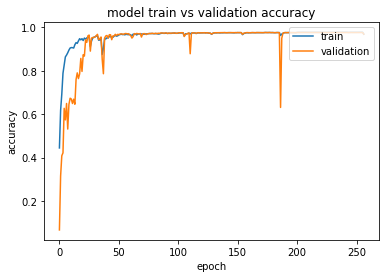

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim((0.95,1))
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

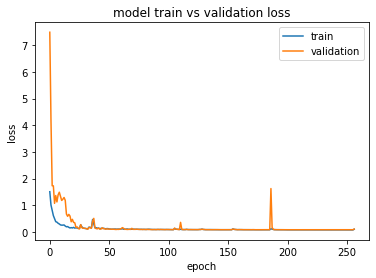

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [38]:
saved_model = load_model('best_model.h5')
#saved_model = model
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_validation, y_validation, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.977, Test: 0.976


In [39]:
pred = np.argmax((saved_model.predict(X_validation)+saved_model.predict(X_validation[:,::-1,:])[:,::-1,:])/2, axis=2).reshape(-1)
gt = np.argmax(y_validation, axis=2).reshape(-1)
print("Macro F1 score: ", np.round(f1_score(gt, pred, average="macro"), 5))

Macro F1 score:  0.95467
